# Download library

In [ ]:
!pip install transformers==4.28.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install accelerate -U

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install git+https://github.com/huggingface/accelerate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/huggingface/accelerate to /tmp/pip-req-build-q9lpmr1g
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/accelerate /tmp/pip-req-build-q9lpmr1g
  Resolved https://github.com/huggingface/accelerate to commit 50eabe5b1d3cde24a9f3b65b6e7e25075b269da4
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
!pip install huggingface_hub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Load data and pre-processing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

os.environ['CURL_CA_BUNDLE'] = ''

In [ ]:
import transformers
from transformers import AdamW, get_linear_schedule_with_warmup
from transformers import BertModel, BertTokenizer
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from tqdm.notebook import tqdm

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [ ]:
df_p = pd.read_csv("/content/drive/MyDrive/thesis_project_files/clean/all_P.csv")
df_r = pd.read_csv("/content/drive/MyDrive/thesis_project_files/clean/all_R.csv")

In [ ]:
df_p = df_p.drop(['Duration', 'comment', 'Role','combine'], axis=1)
df_r = df_r.drop(['Duration', 'comment', 'Role','combine'], axis=1)

In [ ]:
df_r = df_r.rename(columns={"Label":"label", "clean_text":"text"})
df_p = df_p.rename(columns={"Label":"label", "clean_text":"text"})

In [ ]:
# list
R_labels=['introduce background','prepare demonstration', 'provide clarification','additional info',
          'explain behavior','explain resources',
          'refer to resources','refer to simulation',
          'prompt action','prompt clarification','prompt evaluation',
          'confirm intention','provide opinion',
          'summarize discussion','time management','encouragement',
          'prompt resources clarification', 'propose action','propose approximation',
          'propose choice','implement behavior', 'identify failure','explain failure',
          'debugging','identify limitation',
          'robot limitation','resources - setup limitation']


P_labels=['ask for clarification','accept suggestion','accept clarification','call for discussion',
          'propose role','propose behavior',
          'choose behavior','explain proposed behavior',
          'clarification reasoning','refer to experience', 'propose action',
          'propose replacement','propose fixes',
          'propose addition','propose removal',
          'identify failure', 'identify limitation',
          'social context','spatial context','user context','liability concern',
          'safety concern','ethical concern',
          'robot limitation', 'resources - setup limitation',
          'positive','indifferent','anthropomorphize','unsuitable goal',
          'interaction - engagement failure','performance failure',
          'inappropriate behavior','unexpected behavior', 'refer to simulation']

# dict
R_dict = dict(zip(R_labels, range(0,len(R_labels))))
P_dict = dict(zip(P_labels, range(0,len(P_labels))))

In [ ]:
R_dict

{'introduce background': 0,
 'prepare demonstration': 1,
 'provide clarification': 2,
 'additional info': 3,
 'explain behavior': 4,
 'explain resources': 5,
 'refer to resources': 6,
 'refer to simulation': 7,
 'prompt action': 8,
 'prompt clarification': 9,
 'prompt evaluation': 10,
 'confirm intention': 11,
 'provide opinion': 12,
 'summarize discussion': 13,
 'time management': 14,
 'encouragement': 15,
 'prompt resources clarification': 16,
 'propose action': 17,
 'propose approximation': 18,
 'propose choice': 19,
 'implement behavior': 20,
 'identify failure': 21,
 'explain failure': 22,
 'debugging': 23,
 'identify limitation': 24,
 'robot limitation': 25,
 'resources - setup limitation': 26}

In [ ]:
def exclude(df, labels):
  exclude_idx=[]
  for d in range(0, len(df['label'])):
      if  df['label'][d] not in labels:
          exclude_idx.append(d)
  return df.drop(index=(exclude_idx))


df_r=exclude(df_r, R_labels)
df_p=exclude(df_p, P_labels)

In [ ]:
df_p['index']=df_p['label'].apply(P_labels.index)
df_r['index']=df_r['label'].apply(R_labels.index)

# Model

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'huggingface.co'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'huggingface.co'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'huggingface.co'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'huggingface.co'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'huggingface.co'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1045

/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'huggingface.co'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'huggingface.co'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


In [ ]:
class MainDataset(Dataset):

    def __init__(self, text, targets, tokenizer, max_len):
        self.text = text
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, item):
        text = str(self.text[item])
        target = self.targets[item]

        encoding = self.tokenizer.encode_plus(text,
                                              add_special_tokens=True,
                                              max_length=self.max_len,
                                              return_token_type_ids=False,
                                              pad_to_max_length=True,
                                              return_attention_mask=True,
                                              return_tensors='pt',
                                              truncation = True
                                             )
        return {'text': text,
                'input_ids': encoding['input_ids'].flatten(),
                'attention_mask': encoding['attention_mask'].flatten(),
                'targets': torch.tensor(target, dtype=torch.long)}

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = MainDataset(
    text=df['text'].to_numpy(),
    targets=df['index'].to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size
  )

In [ ]:
class Classifier(nn.Module):

  def __init__(self, n_classes):
    super(Classifier, self).__init__()
    self.bert = BertModel.from_pretrained('bert-base-cased')
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask,return_dict=False):
    _, pooled_output = self.bert(input_ids=input_ids,attention_mask=attention_mask, return_dict=False)
    output = self.drop(pooled_output)
    return self.out(output)

In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
class Train_Model:

  def __init__(self, model, loss_fn, optimizer, device, scheduler, n_examples):
    self.model=model
    self.loss_fn=loss_fn
    self.optimizer=optimizer
    self.device=device
    self.scheduler=scheduler
    self.n_examples=n_examples

  def train_epoch(self, train_data_loader):
    model = self.model.train()

    losses = []
    correct_predictions = 0

    for d in tqdm(train_data_loader):
      input_ids = d["input_ids"].to(self.device)
      attention_mask = d["attention_mask"].to(self.device)
      targets = d["targets"].to(self.device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask, return_dict=False
      )

      _, preds = torch.max(outputs, dim=1)
      loss = self.loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

      loss.backward()
      nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
      self.optimizer.step()
      self.scheduler.step()
      self.optimizer.zero_grad()

    return correct_predictions.double() / self.n_examples, np.mean(losses)

  def eval_model(self, val_data_loader):
      model = self.model.eval()

      losses = []
      correct_predictions = 0

      with torch.no_grad():
        for d in tqdm(val_data_loader):
          input_ids = d["input_ids"].to(self.device)
          attention_mask = d["attention_mask"].to(self.device)
          targets = d["targets"].to(self.device)

          outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,return_dict=False
          )
          _, preds = torch.max(outputs, dim=1)

          loss = self.loss_fn(outputs, targets)

          correct_predictions += torch.sum(preds == targets)
          losses.append(loss.item())

      return correct_predictions.double() / self.n_examples, np.mean(losses)

  def get_predictions(self, test_data_loader):
      model = self.model.eval()

      texts = []
      predictions = []
      prediction_probs = []
      real_values = []

      with torch.no_grad():
        for d in test_data_loader:

          text = d["text"]
          input_ids = d["input_ids"].to(self.device)
          attention_mask = d["attention_mask"].to(self.device)
          targets = d["targets"].to(self.device)

          outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
          )
          _, preds = torch.max(outputs, dim=1)

          probs = F.softmax(outputs, dim=1)

          texts.extend(text)
          predictions.extend(preds)
          prediction_probs.extend(probs)
          real_values.extend(targets)

      predictions = torch.stack(predictions).cpu()
      prediction_probs = torch.stack(prediction_probs).cpu()
      real_values = torch.stack(real_values).cpu()
      return texts, predictions, prediction_probs, real_values

# Researcher

In [ ]:
train_r, test_r = train_test_split(df_r, test_size=0.2)
valid_r, test_r = train_test_split(test_r, test_size=0.5)

In [ ]:
train_data_loader_r = create_data_loader(train_r, tokenizer, max_len=128, batch_size=16)
val_data_loader_r = create_data_loader(valid_r, tokenizer, max_len=128, batch_size=16)
test_data_loader_r = create_data_loader(test_r, tokenizer, max_len=128, batch_size=16)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
# define parameters
EPOCHS = 5

model = Classifier(len(R_labels))
model = model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader_r) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps)

loss_fn = nn.CrossEntropyLoss().to(device)

# define researcher's model

R_model_train=Train_Model(model, loss_fn, optimizer, device, scheduler, len(train_r))

/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'huggingface.co'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkp

In [ ]:
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = R_model_train.train_epoch(train_data_loader_r)

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = R_model_train.eval_model(val_data_loader_r)

  print(f'Val loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/5
----------


  0%|          | 0/114 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Train loss 2.8324967058081376 accuracy 0.18461538461538463


  0%|          | 0/15 [00:00<?, ?it/s]

Val loss 2.628312412897746 accuracy 0.026373626373626374

Epoch 2/5
----------


  0%|          | 0/114 [00:00<?, ?it/s]

Train loss 2.3121068111637184 accuracy 0.3038461538461538


  0%|          | 0/15 [00:00<?, ?it/s]

Val loss 2.4224320888519286 accuracy 0.03296703296703297

Epoch 3/5
----------


  0%|          | 0/114 [00:00<?, ?it/s]

Train loss 1.9061357054794044 accuracy 0.43351648351648353


  0%|          | 0/15 [00:00<?, ?it/s]

Val loss 2.320697871843974 accuracy 0.04010989010989011

Epoch 4/5
----------


  0%|          | 0/114 [00:00<?, ?it/s]

Train loss 1.5923011067666506 accuracy 0.5395604395604395


  0%|          | 0/15 [00:00<?, ?it/s]

Val loss 2.31733291943868 accuracy 0.04120879120879121

Epoch 5/5
----------


  0%|          | 0/114 [00:00<?, ?it/s]

Train loss 1.4282772300536173 accuracy 0.5945054945054945


  0%|          | 0/15 [00:00<?, ?it/s]

Val loss 2.3252968549728394 accuracy 0.03956043956043956



In [80]:
y_texts, y_pred, y_pred_probs, y_test = R_model_train.get_predictions(test_data_loader_r)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
from sklearn.metrics import balanced_accuracy_score

acc=balanced_accuracy_score(y_test, y_pred)
acc

0.23026029081521077

In [81]:
y_test_set=list(set(y_test.tolist()))
y_pred_set=list(set(y_pred.tolist()))

In [90]:
def get_key(list_set, dictionary):
  name=[]
  for n in range(0, len(list_set)):
    for key, value in dictionary.items():
      if list_set[n] == value:
        name.append(key)
  return name

  return "key doesn't exist"

y_test_name=get_key(y_test_set, R_dict)
y_pred_name=get_key(y_pred_set, R_dict)

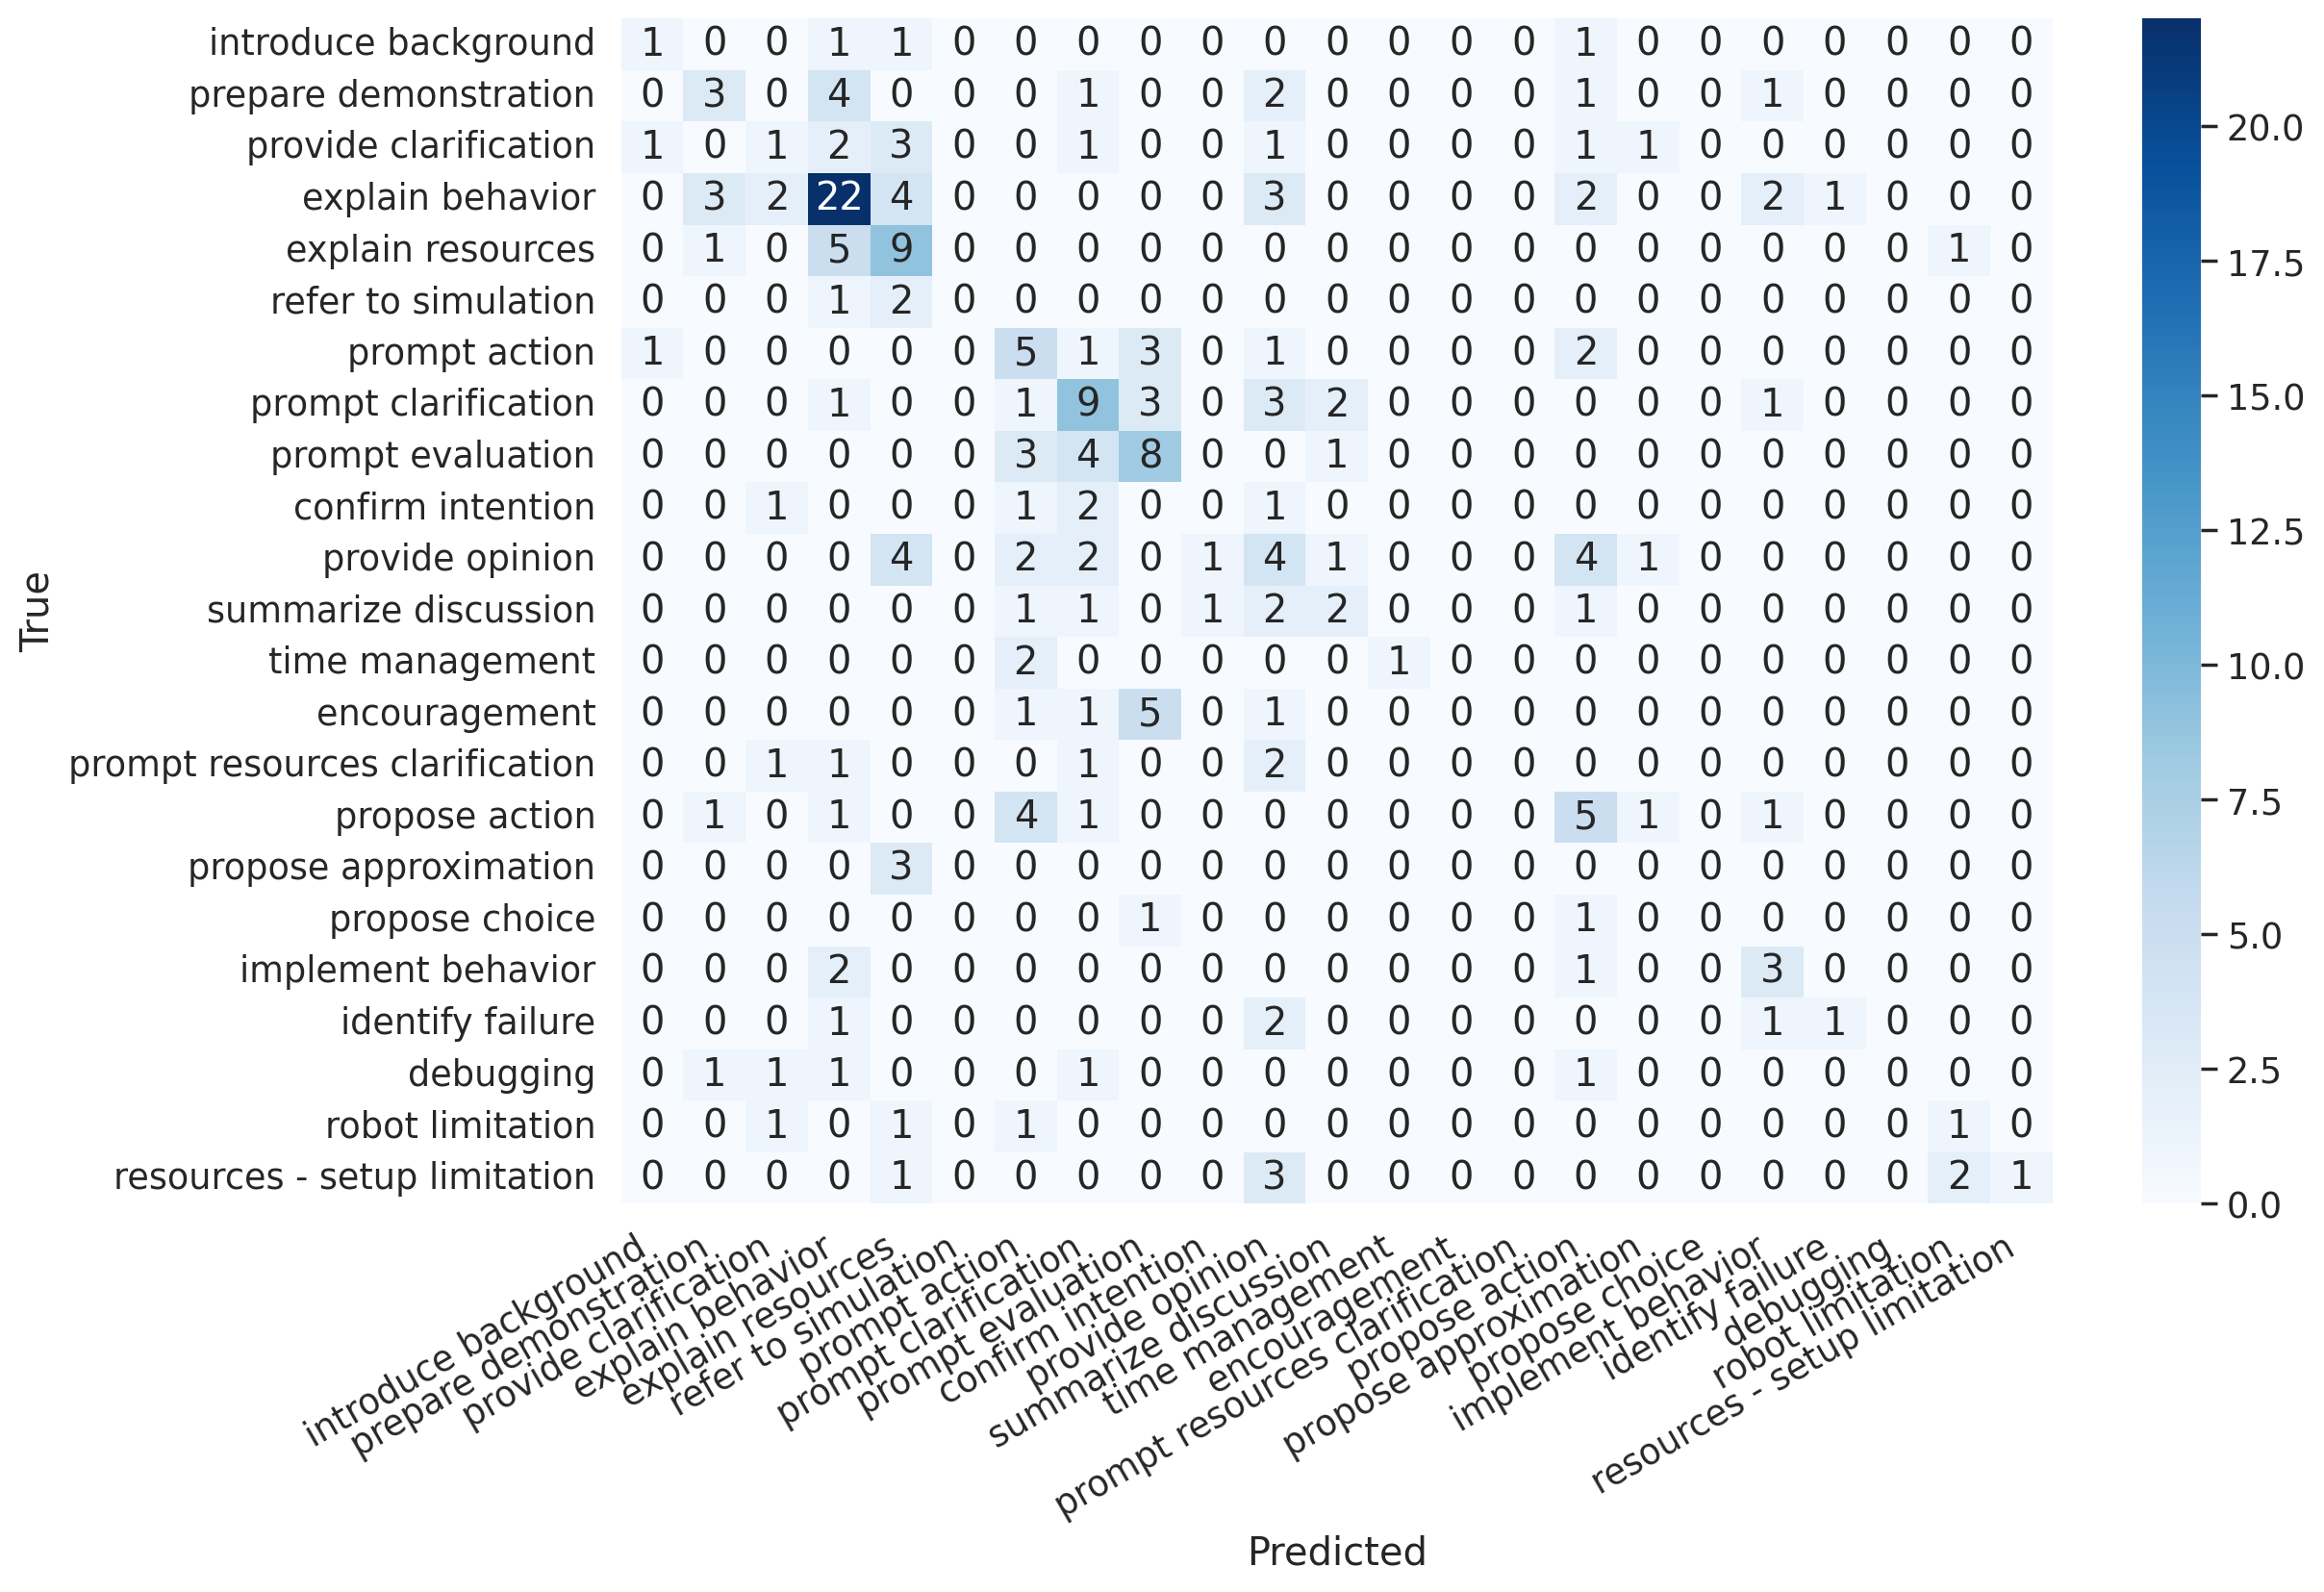

In [92]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True')
  plt.xlabel('Predicted');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=y_test_name, columns=y_test_name)
show_confusion_matrix(df_cm)

In [93]:
print(classification_report(y_test, y_pred, target_names=y_test_name))

                                precision    recall  f1-score   support

          introduce background       0.33      0.25      0.29         4
         prepare demonstration       0.33      0.25      0.29        12
         provide clarification       0.14      0.09      0.11        11
              explain behavior       0.52      0.56      0.54        39
             explain resources       0.32      0.56      0.41        16
           refer to simulation       0.00      0.00      0.00         3
                 prompt action       0.24      0.38      0.29        13
          prompt clarification       0.36      0.45      0.40        20
             prompt evaluation       0.40      0.50      0.44        16
             confirm intention       0.00      0.00      0.00         5
               provide opinion       0.16      0.21      0.18        19
          summarize discussion       0.33      0.25      0.29         8
               time management       1.00      0.33      0.50  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Participant

In [94]:
train_p, test_p = train_test_split(df_p, test_size=0.2)
valid_p, test_r = train_test_split(test_p, test_size=0.5)

In [95]:
train_data_loader_p = create_data_loader(train_p, tokenizer, max_len=128, batch_size=16)
val_data_loader_p = create_data_loader(valid_p, tokenizer, max_len=128, batch_size=16)
test_data_loader_p = create_data_loader(test_p, tokenizer, max_len=128, batch_size=16)

In [96]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [97]:
# define parameters
EPOCHS = 5

model = Classifier(len(P_labels))
model = model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader_p) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps)

loss_fn = nn.CrossEntropyLoss().to(device)

# define researcher's model

P_model_train=Train_Model(model, loss_fn, optimizer, device, scheduler, len(train_p))

/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'huggingface.co'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkp

In [98]:
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = P_model_train.train_epoch(train_data_loader_p)

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = P_model_train.eval_model(val_data_loader_p)

  print(f'Val loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/5
----------


  0%|          | 0/91 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Train loss 3.187779188156128 accuracy 0.09615384615384616


  0%|          | 0/12 [00:00<?, ?it/s]

Val loss 3.1558141907056174 accuracy 0.013736263736263738

Epoch 2/5
----------


  0%|          | 0/91 [00:00<?, ?it/s]

Train loss 2.983806942845439 accuracy 0.14903846153846154


  0%|          | 0/12 [00:00<?, ?it/s]

Val loss 2.946032702922821 accuracy 0.028846153846153848

Epoch 3/5
----------


  0%|          | 0/91 [00:00<?, ?it/s]

Train loss 2.6377209765570506 accuracy 0.2967032967032967


  0%|          | 0/12 [00:00<?, ?it/s]

Val loss 2.793580333391825 accuracy 0.029532967032967036

Epoch 4/5
----------


  0%|          | 0/91 [00:00<?, ?it/s]

Train loss 2.224264695094182 accuracy 0.4244505494505495


  0%|          | 0/12 [00:00<?, ?it/s]

Val loss 2.7473188440004983 accuracy 0.030906593406593408

Epoch 5/5
----------


  0%|          | 0/91 [00:00<?, ?it/s]

Train loss 1.9658275986765767 accuracy 0.5096153846153847


  0%|          | 0/12 [00:00<?, ?it/s]

Val loss 2.744370440642039 accuracy 0.0315934065934066



In [99]:
y_texts, y_pred, y_pred_probs, y_test = P_model_train.get_predictions(test_data_loader_p)

In [100]:
from sklearn.metrics import balanced_accuracy_score

acc=balanced_accuracy_score(y_test, y_pred)
acc

0.1295777522018825

In [101]:
y_test_set=list(set(y_test.tolist()))
y_pred_set=list(set(y_pred.tolist()))

In [108]:
def get_key(list_set, dictionary):
  name=[]
  for n in range(0, len(list_set)):
    for key, value in dictionary.items():
      if list_set[n] == value:
        name.append(key)
  return name

  return "key doesn't exist"

y_test_name=get_key(y_test_set, P_dict)
y_pred_name=get_key(y_pred_set, P_dict)

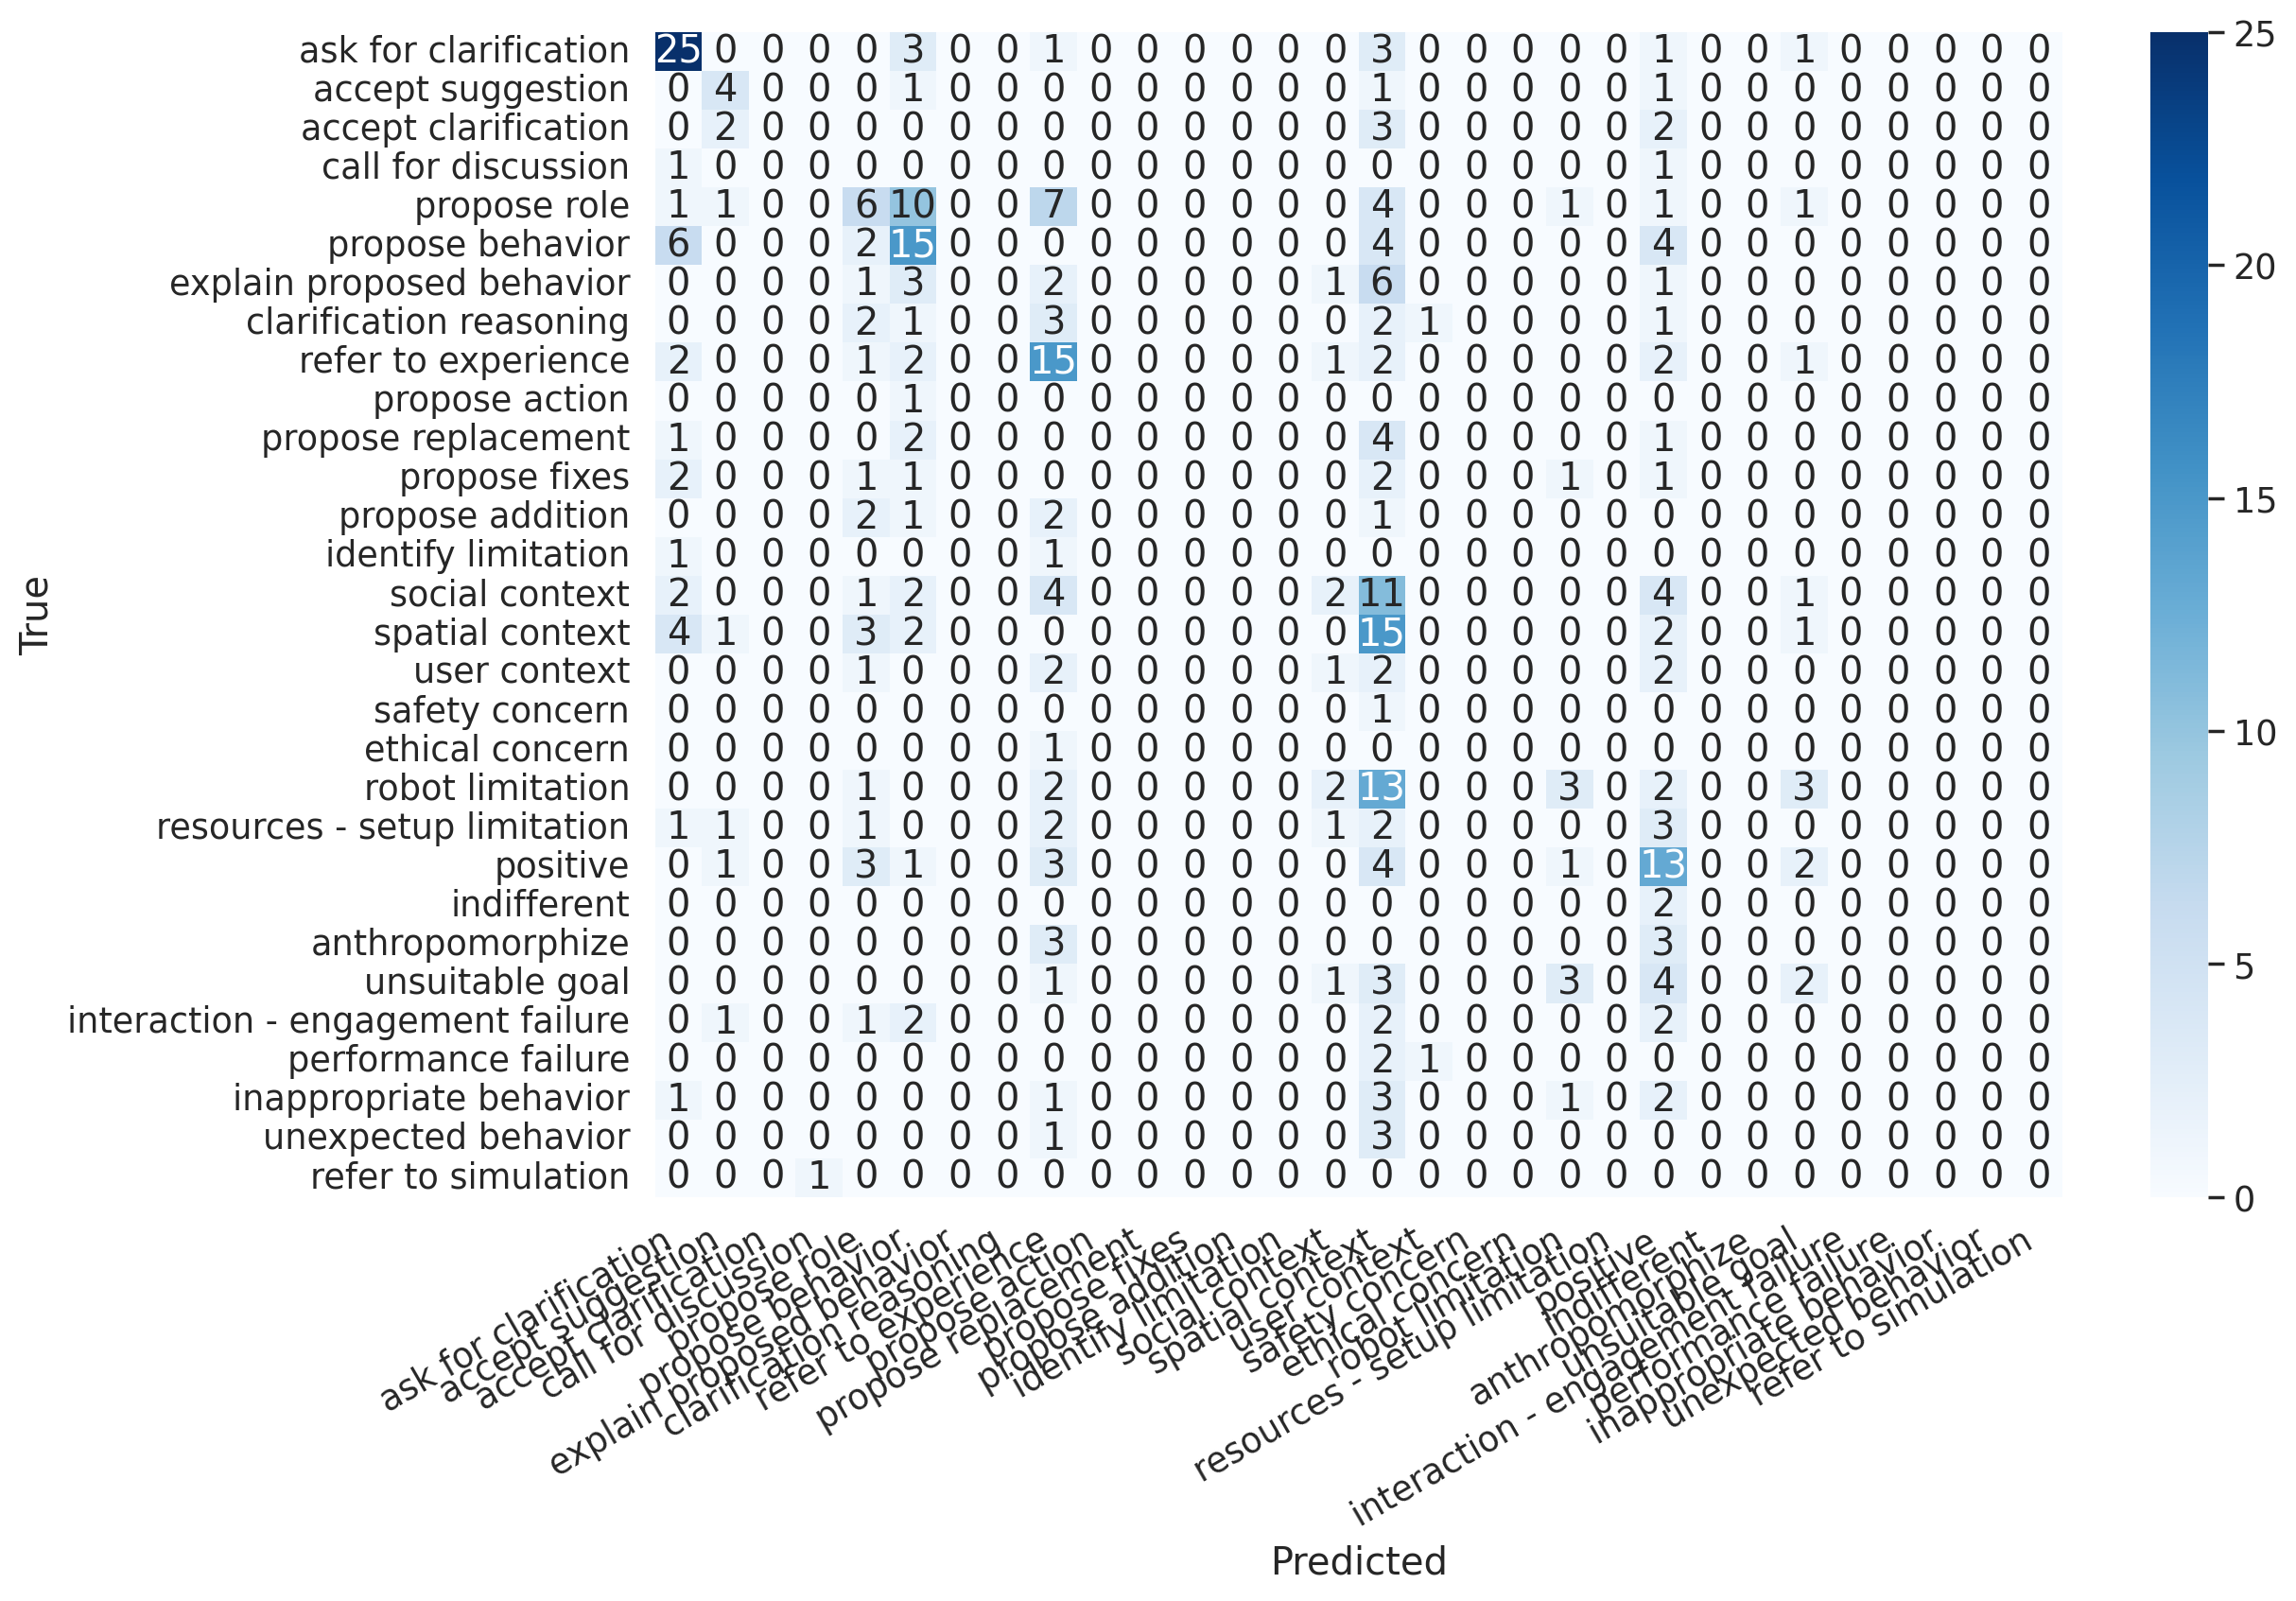

In [109]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True')
  plt.xlabel('Predicted');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=y_test_name, columns=y_test_name)
show_confusion_matrix(df_cm)

In [111]:
print(classification_report(y_test, y_pred, target_names=y_test_name))

                                  precision    recall  f1-score   support

           ask for clarification       0.53      0.74      0.62        34
               accept suggestion       0.36      0.57      0.44         7
            accept clarification       0.00      0.00      0.00         7
             call for discussion       0.00      0.00      0.00         2
                    propose role       0.23      0.19      0.21        32
                propose behavior       0.32      0.48      0.38        31
       explain proposed behavior       0.00      0.00      0.00        14
         clarification reasoning       0.00      0.00      0.00        10
             refer to experience       0.29      0.58      0.39        26
                  propose action       0.00      0.00      0.00         1
             propose replacement       0.00      0.00      0.00         8
                   propose fixes       0.00      0.00      0.00         8
                propose addition     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
